# 3.torch.nn.Modules及拓展新的Modules

## 拓展新的torch.nn.Modules

### 是什么
* pytorch中有两种拓展pytorch方式，一种是拓展Function（后面将介绍），一种是就是拓展Modules
* 之前2中，我们知道torch.nn包中的各个类实际上就是由torch.nn.Modules拓展
* torch.nn.Modules相当于是对网络某种层的封装，包括网络结构以及网络参数，和其他有用的操作如输出参数

### 如何拓展
* 进行拓展，需要继承Modules类，并实现\__init\__()方法，以及forward()方法
* \__init\__()方法，用于定义一些新的属性，这些属性可以包括Modules的实例，如一个`nn.Conv2d`。即创建该网络中的子网络，在创建这些子网络时，这些网络的参数也被初始化
* forward()方法，用于定义在这个Module进行forward时的计算顺序，forward()方法接受一个输入，然后通过其他modules或者其他Function运算，来进行forward，返回一个输出结果

### 作用
* Module的作用就是可以结构化定义网络的层，并提供对该层的封装，包括该层的结构，参数以及一些其他操作
* Module中的forward可以使用其他Module，其在调用forward时，其内部其他Module将按顺序进行forward（具体见例子）

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class MyBlock(nn.Module):
    def __init__(self):
        # 调用Module的初始化
        super(MyBlock, self).__init__()
        
        # 创建将要调用的子层（Module），注意：此时还并未实现MyBlock网络的结构，只是初始化了其子层（结构+参数）
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 3, 3)
        
    def forward(self, x):
        
        # 这里relu与pool层选择用Function来实现，而不使用Module，用Module也可以
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        return x
        
test_MyBlock = MyBlock()

# 可以看Module中的子Module
print test_MyBlock

# 可以通过Module中的多种方法，实现输出参数等功能
print(test_MyBlock.state_dict().keys())

# 可以直接对Module中的子Module进行修改
test_MyBlock.conv1 = nn.Conv2d(1, 3, 5)
print test_MyBlock.conv1

MyBlock (
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
)
['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias']
Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))


## Simple VggNet
下面，将利用上面建立的MyBlock建立一个简单的VggNet

In [2]:
class SimpleVgg(nn.Module):
    def __init__(self):
        super(SimpleVgg, self).__init__()
        self.block1 = MyBlock()
        self.block2 = MyBlock()
        self.block2.conv1 = nn.Conv2d(3, 3, 3)
        self.fc = nn.Linear(75, 10)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        
        # 将3维张量化为1维向量
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

vgg = SimpleVgg()

print vgg

SimpleVgg (
  (block1): MyBlock (
    (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (block2): MyBlock (
    (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (fc): Linear (75 -> 10)
)


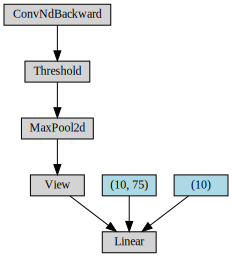

In [3]:
from graphviz import Digraph
import re


def make_dot(var):
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def add_nodes(var):
        if var not in seen:
            if isinstance(var, Variable):
                value = '('+(', ').join(['%d'% v for v in var.size()])+')'
                dot.node(str(id(var)), str(value), fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'previous_functions'):
                for u in var.previous_functions:
                    dot.edge(str(id(u[0])), str(id(var)))
                    add_nodes(u[0])
    add_nodes(var.creator)
    return dot

input_ = Variable(torch.randn((1, 1, 32, 32)))
out = vgg(input_)
g = make_dot(out)
g